# Gaussian Process Distribution of Relaxation Times. 

## In this tutorial we will show use the GP-DRT method to analyze actual experimental data

The impedance data in the csv file named `EIS_experiment.csv`. The file has three columns. The first column is the frequency, the second one the real part of the impedance. The third column is the imaginary part of impedance. To use this tutorial for your own data, we recommend the frequencies go are sorted ascendingly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
import pandas as pd
%matplotlib inline

## 1) Read in the impedance data from the csv file
### IMPORTANT: frequencies should be sorted ascendingly (low to high)

In [2]:
Z_data = pd.read_csv('EIS_experiment.csv')
freq_vec, Z_exp = Z_data['freq'].values, Z_data['Z_real'].values+1j*Z_data['Z_imag'].values

# define the frequency range
N_freqs = len(freq_vec)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction, we choose a wider range to better display the DRT
freq_vec_star = np.logspace(-4., 6., num=101, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# finer mesh for plotting only
freq_vec_plot  = np.logspace(-4., 6., num=1001, endpoint=True)

## 2) Show the impedance spectrum as a Nyquist plot

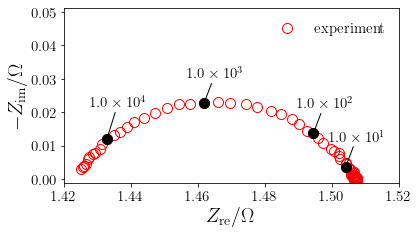

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the EIS spectrum
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, fillstyle='none', color="red", label="experiment")
plt.plot(np.real(Z_exp[40:80:10]), -np.imag(Z_exp[40:80:10]), 'o', markersize=10, color="black")

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

# this depends on the data used - if you wish to use your own data you may need to modify this
plt.xlim(1.42, 1.52)
plt.ylim(-0.001, 0.051)
plt.xticks(np.arange(1.42, 1.521, 0.02))
plt.yticks(np.arange(0.00, 0.051, 0.01))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

# label the frequencies - if you wish to use your own data you may need to modify this
label_index = range(40,80,10)
move = [[-0.005, 0.008], [-0.005, 0.008], [-0.005, 0.008], [-0.005, 0.01]]
for k, ind in enumerate(label_index):
    power = int(np.log10(freq_vec[ind]))
    num = freq_vec[ind]/(10**(power))
    plt.annotate(r'${0:.1f}\times 10^{1}$'.format(num, power), xy=(np.real(Z_exp[ind]), -np.imag(Z_exp[ind])), 
                 xytext=(np.real(Z_exp[ind])+move[k][0], move[k][1]-np.imag(Z_exp[ind])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.show()

## 3) Compute the optimal hyperparameters
### Note: the intial parameters may adjusting

In [4]:
# initial parameters parameter to maximize the marginal log-likelihood as shown in eq (31)
sigma_n = 3.0E-4
sigma_f = 6.0E-3
ell = 2.0

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}'.format(theta[0], theta[1], theta[2]))
    
print('sigma_n,   sigma_f,   ell')

# minimize the NMLL $L(\theta)$ w.r.t sigma_n, sigma_f, ell using the BFGS method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Nelder-Mead', \
               callback=print_results, options={'disp': True})

theta_0 = res.x
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='BFGS', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

sigma_n,   sigma_f,   ell
0.0003150  0.0063000  1.8000000
0.0002850  0.0066000  1.8000000
0.0002850  0.0066000  1.8000000
0.0002850  0.0066000  1.8000000
0.0003050  0.0065000  1.7666667
0.0003050  0.0065000  1.7666667
0.0002972  0.0066778  1.7722222
0.0002945  0.0065796  1.8231481
0.0002920  0.0065929  1.7936728
0.0002920  0.0065929  1.7936728
0.0002963  0.0066274  1.7858325
0.0002953  0.0065863  1.8050762
0.0002972  0.0065803  1.7881838
0.0002941  0.0065954  1.7933518
0.0002947  0.0065473  1.8052421
0.0002954  0.0065624  1.7861090
0.0002954  0.0065624  1.7861090
0.0002966  0.0065272  1.7952438
0.0002966  0.0065272  1.7952438
0.0002954  0.0064920  1.7963716
0.0002966  0.0064797  1.7815173
0.0002966  0.0064797  1.7815173
0.0002959  0.0063540  1.7833807
0.0002949  0.0064469  1.7782003
0.0002949  0.0064469  1.7782003
0.0002949  0.0064469  1.7782003
0.0002957  0.0063636  1.7714437
0.0002952  0.0063418  1.7738371
0.0002956  0.0063690  1.7789372
0.0002952  0.0064025  1.7764698
0.0002955  0.0

## 4) Core of the GP-DRT

### 4a) Compute matrices

In [5]:
# calculate the matrices shown in eq (18)
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

### 4b) Factorize the matrices and solve the linear equations

In [6]:
# the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ whose inverse is needed
K_im_full = L2_im_K + Sigma

# Cholesky factorization, L is a lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a)
gamma_fct_est = np.dot(L_im_K, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)

# estimate the sigma of gamma for eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K, np.dot(inv_K_im_full, L_im_K.T))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

### 4c) Predict the imaginary part of the GP-DRT and impedance

In [7]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (18), xi_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star_up = GP_DRT.matrix_L_im_K(xi_star, xi_vec, sigma_f, ell)
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star - np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute gamma_star mean and standard deviation using eq (29)
    gamma_vec_star[index] = np.dot(L_im_k_star_up, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star - np.dot(L_im_k_star_up, np.dot(inv_K_im_full, L_im_k_star_up.T))

### 4d) Plot the obtained GP-DRT

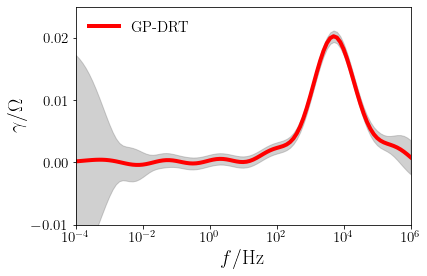

In [8]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_star, gamma_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, gamma_vec_star-3*np.sqrt(abs(Sigma_gamma_vec_star)), gamma_vec_star+3*np.sqrt(abs(Sigma_gamma_vec_star)), color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E6,-0.01,0.025])
plt.yticks(np.arange(-0.01, 0.025, 0.01))
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4e) Plot the imaginary part of the GP-DRT impedance together with the experimental one

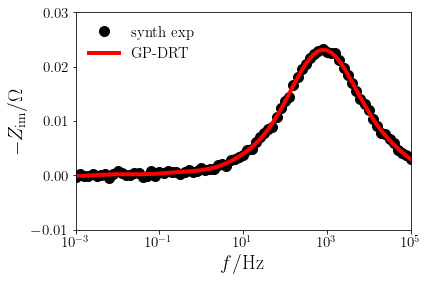

In [9]:
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+\
                 3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-3,1E5,-0.01,0.03])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()